In [115]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
#from scipy import stats
import seaborn as sns
#from sklearn.preprocessing import StandardScaler, LabelEncoder
import sklearn.preprocessing as preprocessing
#import statsmodels.formula.api as smf
#import statsmodels.api as smf
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('notebook')
import arviz as az
#import theano

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
print(pm.__version__, np.__version__, pd.__version__)

3.6 1.16.4 0.25.0


In [3]:
SEED = 1234567890
np.random.seed(SEED)

In [4]:
d = pd.read_csv('Data/Wines2012.csv', sep=';', header=0)

# extract wines with score data (remove those without)
dd = d[np.isfinite(d['score'])]

In [5]:
# Standardize the score
#scaler = StandardScaler()
#s = scaler.fit_transform(dd[['score']])      #need to flatten numpy array using .flatten() as below in order to get in correct shape for use with jid and wid in pymc3, otherwise get crap out!
#s = np.array(s).flatten()         
s = preprocessing.scale(dd['score'])        #this naturally returns the correct shape, so no further processing needed, unlike when StandardScaler() is used.

# je = LabelEncoder()     #Encodes judges with label from 0 to n-1
# je.fit(dd["judge"])
# list(je.classes_)
# jid = (je.transform(dd["judge"]))

# we = LabelEncoder()     #Encodes wines with label from 0 to n-1
# we.fit(dd["wine"])
# list(we.classes_)
# wid = we.transform(dd["wine"])

# The above also works, but the lines below are simpler (thanks Gabi!)
jid = d['judge'].astype('category').cat.codes
flight_fact = d['flight'].astype('category').cat.codes
#flight_fact = pd.factorize(d['flight'])[0] # both options to categorize flight are perfectly fine
wid = d['wine'].astype('category').cat.codes

Justify the priors.

The variable s is centered around 0 for the whole population of predictor values.  The predictors are categorical index variable with equivalent priors for each index.  Thus, we can consider the distribution for one index.  The value for the bJ[i] variable is the 'bias' that judge i has towards the scoring variable s.  Judge i may be a generous scorer, at which point they will score all wines highly and s will be >0, or they may be the opposite and score all wines poorly, s<0.  The value of bJ indicates this bias as an average across all the wines they rate.  bW[k] on the other hand represnts a wine k's average (centered) score s amongst all judges, so if bW[k] is high, that means that the judges on average thought that it was a great wine.

Thus, because s is standardized, we can assume a min value of -2 and a max value of +2 (covering approx 95% of the distribution, assuming normality).  Take an index combination of judge i and wine k: if we assume bW[k] = 0, i.e. wine k is an average wine with no positive or negative bias in scoring, then all the potential movement of s must be down to judge i's bias.  bJ[i] could therefore technically range from -2 to +2.  However, let us use some common sense.  If a judge has such a large bias, they are unlikely to be asked to be involved to judge in this international competition.  Therefore, the bias is likely to be much smaller. A reasonably weak prior would therefore likely range from -1 to +1, suggesting a normal distribution of mean 0 and sd around 0.5.

We can use the same argument independently to bW, again assuming that only the finest wines are exhibited at this international competition and thus should be of reasonably similar qualities.  Thus, bW should also have a normal distribution of mean 0 and sd around 0.5.

Note that we also do not use the intercept term 'a', because the score s is centred.

In [6]:
with pm.Model() as Mod1:
#    a = pm.Normal("a", mu=0, sd=0.5)
    bJ = pm.Normal("bJ", mu=0, sd=0.5, shape=len(set(jid)))
    bW = pm.Normal("bW", mu=0, sd=0.5, shape=len(set(wid)))
    mu = bJ[jid] + bW[wid]      #s is centred, so no need to include intercept variable 'a'
#    mu = pm.Deterministic("mu", bJ[jid] + bW[wid])
    sigma = pm.Exponential('sigma', lam=1)
    s_hat = pm.Normal("s_hat", mu=mu, sd=sigma, observed=s)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior_1 = pm.sample(chains=4, cores=4)
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtens

In [7]:
pm.summary(posterior_1, alpha=.11)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd  mc_error   hpd_5.5  hpd_94.5        n_eff  \
bJ__0  -0.280838  0.201597  0.004396 -0.616560  0.017542  2252.672350   
bJ__1   0.213949  0.194292  0.004307 -0.122217  0.498211  2095.678799   
bJ__2   0.201224  0.197067  0.004837 -0.100127  0.511759  1832.681473   
bJ__3  -0.545033  0.196748  0.004256 -0.853972 -0.227822  2215.304339   
bJ__4   0.792982  0.196585  0.004720  0.465278  1.083181  1978.500802   
bJ__5   0.468663  0.196234  0.004511  0.133654  0.758140  2009.977399   
bJ__6   0.127161  0.192389  0.004383 -0.157282  0.447571  2080.068304   
bJ__7  -0.661130  0.198745  0.004653 -0.980401 -0.348364  1945.221108   
bJ__8  -0.353701  0.191566  0.004888 -0.638469 -0.036047  2071.630075   
bW__0   0.126752  0.256677  0.005365 -0.294014  0.523461  2685.611868   
bW__1   0.092229  0.256682  0.005275 -0.325036  0.490763  2754.119205   
bW__2   0.231826  0.249688  0.004991 -0.158408  0.625695  2932.810533   
bW__3   0.471979  0.263588  0.005164  0.035996  0.894007  2749.159907   
bW__4  -0.102931  0.263736  0.005131 -0.527944  0.299408  2723.663614   
bW__5  -0.310693  0.255830  0.004306 -0.711806  0.106478  3011.979505   
bW__6   0.247477  0.264220  0.005080 -0.195445  0.631278  2708.466855   
bW__7   0.238360  0.260245  0.005160 -0.198636  0.635922  3371.565874   
bW__8   0.071372  0.254162  0.005018 -0.332325  0.471416  2616.595070   
bW__9   0.105155  0.263436  0.005423 -0.354258  0.487172  2426.555865   
bW__10 -0.006690  0.257779  0.004479 -0.432316  0.376846  3973.615467   
bW__11 -0.028764  0.253033  0.005082 -0.452614  0.346574  2724.688883   
bW__12 -0.089283  0.254163  0.005081 -0.451233  0.362398  3259.466974   
bW__13  0.001287  0.252133  0.005123 -0.423216  0.373655  2559.349899   
bW__14 -0.175214  0.252901  0.004551 -0.607016  0.193999  3116.881511   
bW__15 -0.160122  0.262941  0.004933 -0.583930  0.267047  2896.729330   
bW__16 -0.114840  0.251157  0.004678 -0.545217  0.245856  3341.571673   
bW__17 -0.715755  0.252557  0.005035 -1.121907 -0.316539  2618.756928   
bW__18 -0.129436  0.259486  0.005376 -0.531232  0.287361  2865.667288   
bW__19  0.322783  0.267647  0.005335 -0.117981  0.717745  2801.553721   
sigma   0.851311  0.050495  0.000927  0.766709  0.925029  3428.013336   

            Rhat  
bJ__0   0.999616  
bJ__1   1.000104  
bJ__2   1.000413  
bJ__3   0.999414  
bJ__4   1.000068  
bJ__5   0.999665  
bJ__6   0.999626  
bJ__7   0.999738  
bJ__8   0.999514  
bW__0   0.999029  
bW__1   0.999094  
bW__2   0.999105  
bW__3   1.000137  
bW__4   1.000121  
bW__5   0.999236  
bW__6   0.999607  
bW__7   0.999266  
bW__8   0.999609  
bW__9   0.999235  
bW__10  0.999948  
bW__11  0.999637  
bW__12  0.999965  
bW__13  0.999781  
bW__14  0.999259  
bW__15  1.000235  
bW__16  0.999620  
bW__17  1.000062  
bW__18  0.999888  
bW__19  0.999379  
sigma   0.999606

In [8]:
pm.waic(posterior_1, model=Mod1)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to f

WAIC_r(WAIC=475.3346781040028, WAIC_se=18.322107660044864, p_WAIC=21.50069597795853, var_warn=1)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


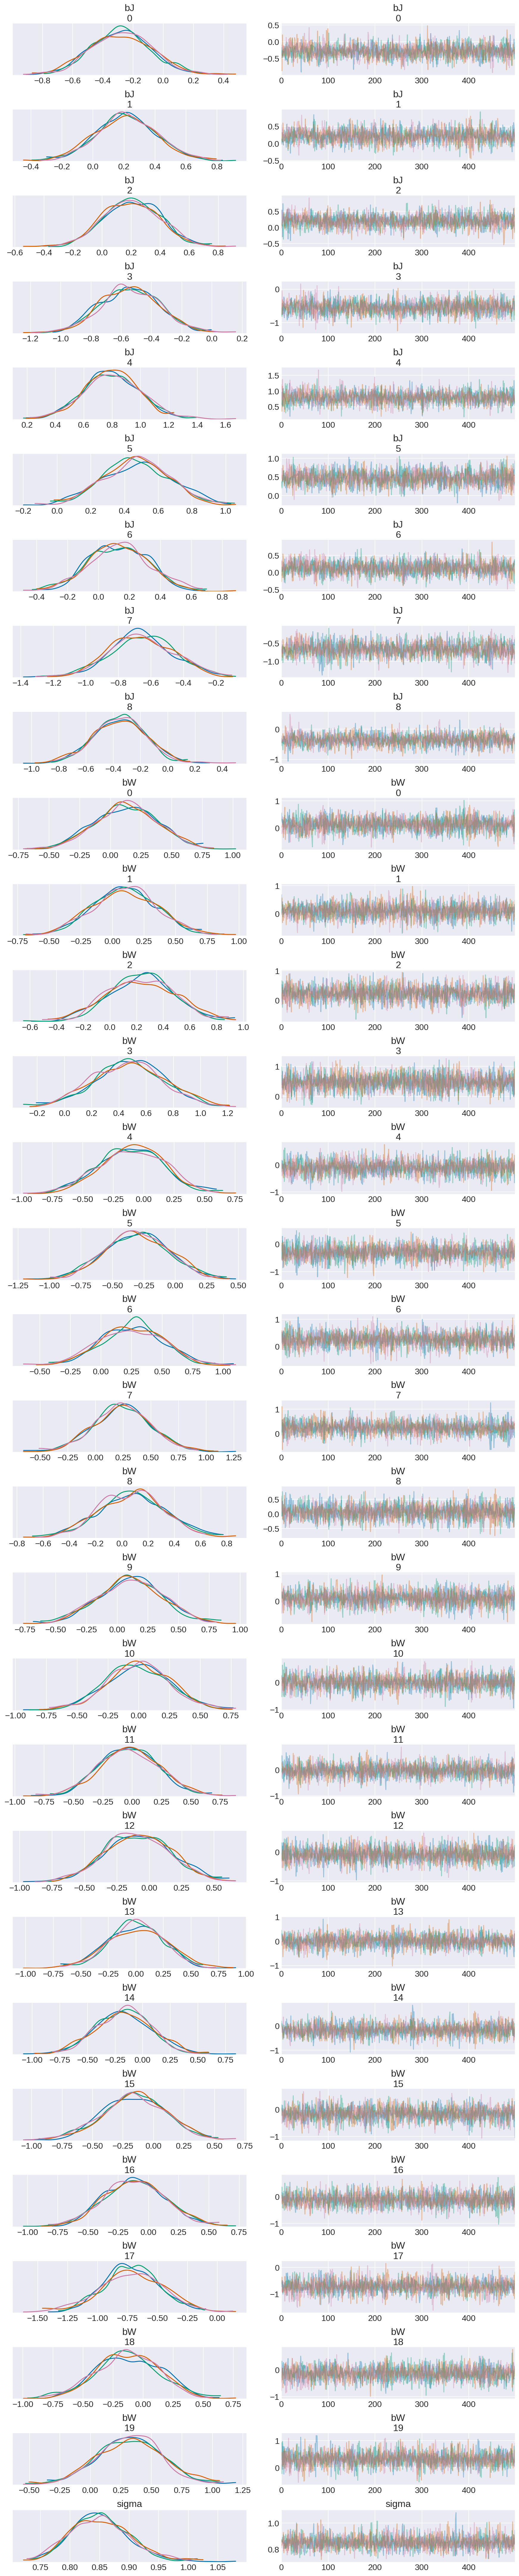

In [9]:
varnames = ['bJ', 'bW', 'sigma']
pm.traceplot(posterior_1, varnames);

How do you interpret the variation among individual judges and individual wines? Do you notice any patterns, just by plotting the differences?
Which judges gave the highest/lowest ratings? Which wines were rated worst/
best on average?

In [10]:
data = az.from_pymc3(trace=posterior_1,
                     prior=prior,
                     posterior_predictive=posterior_pred_1)
data

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/plots/forestplot.py:176: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/plots/forestplot.py:177: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


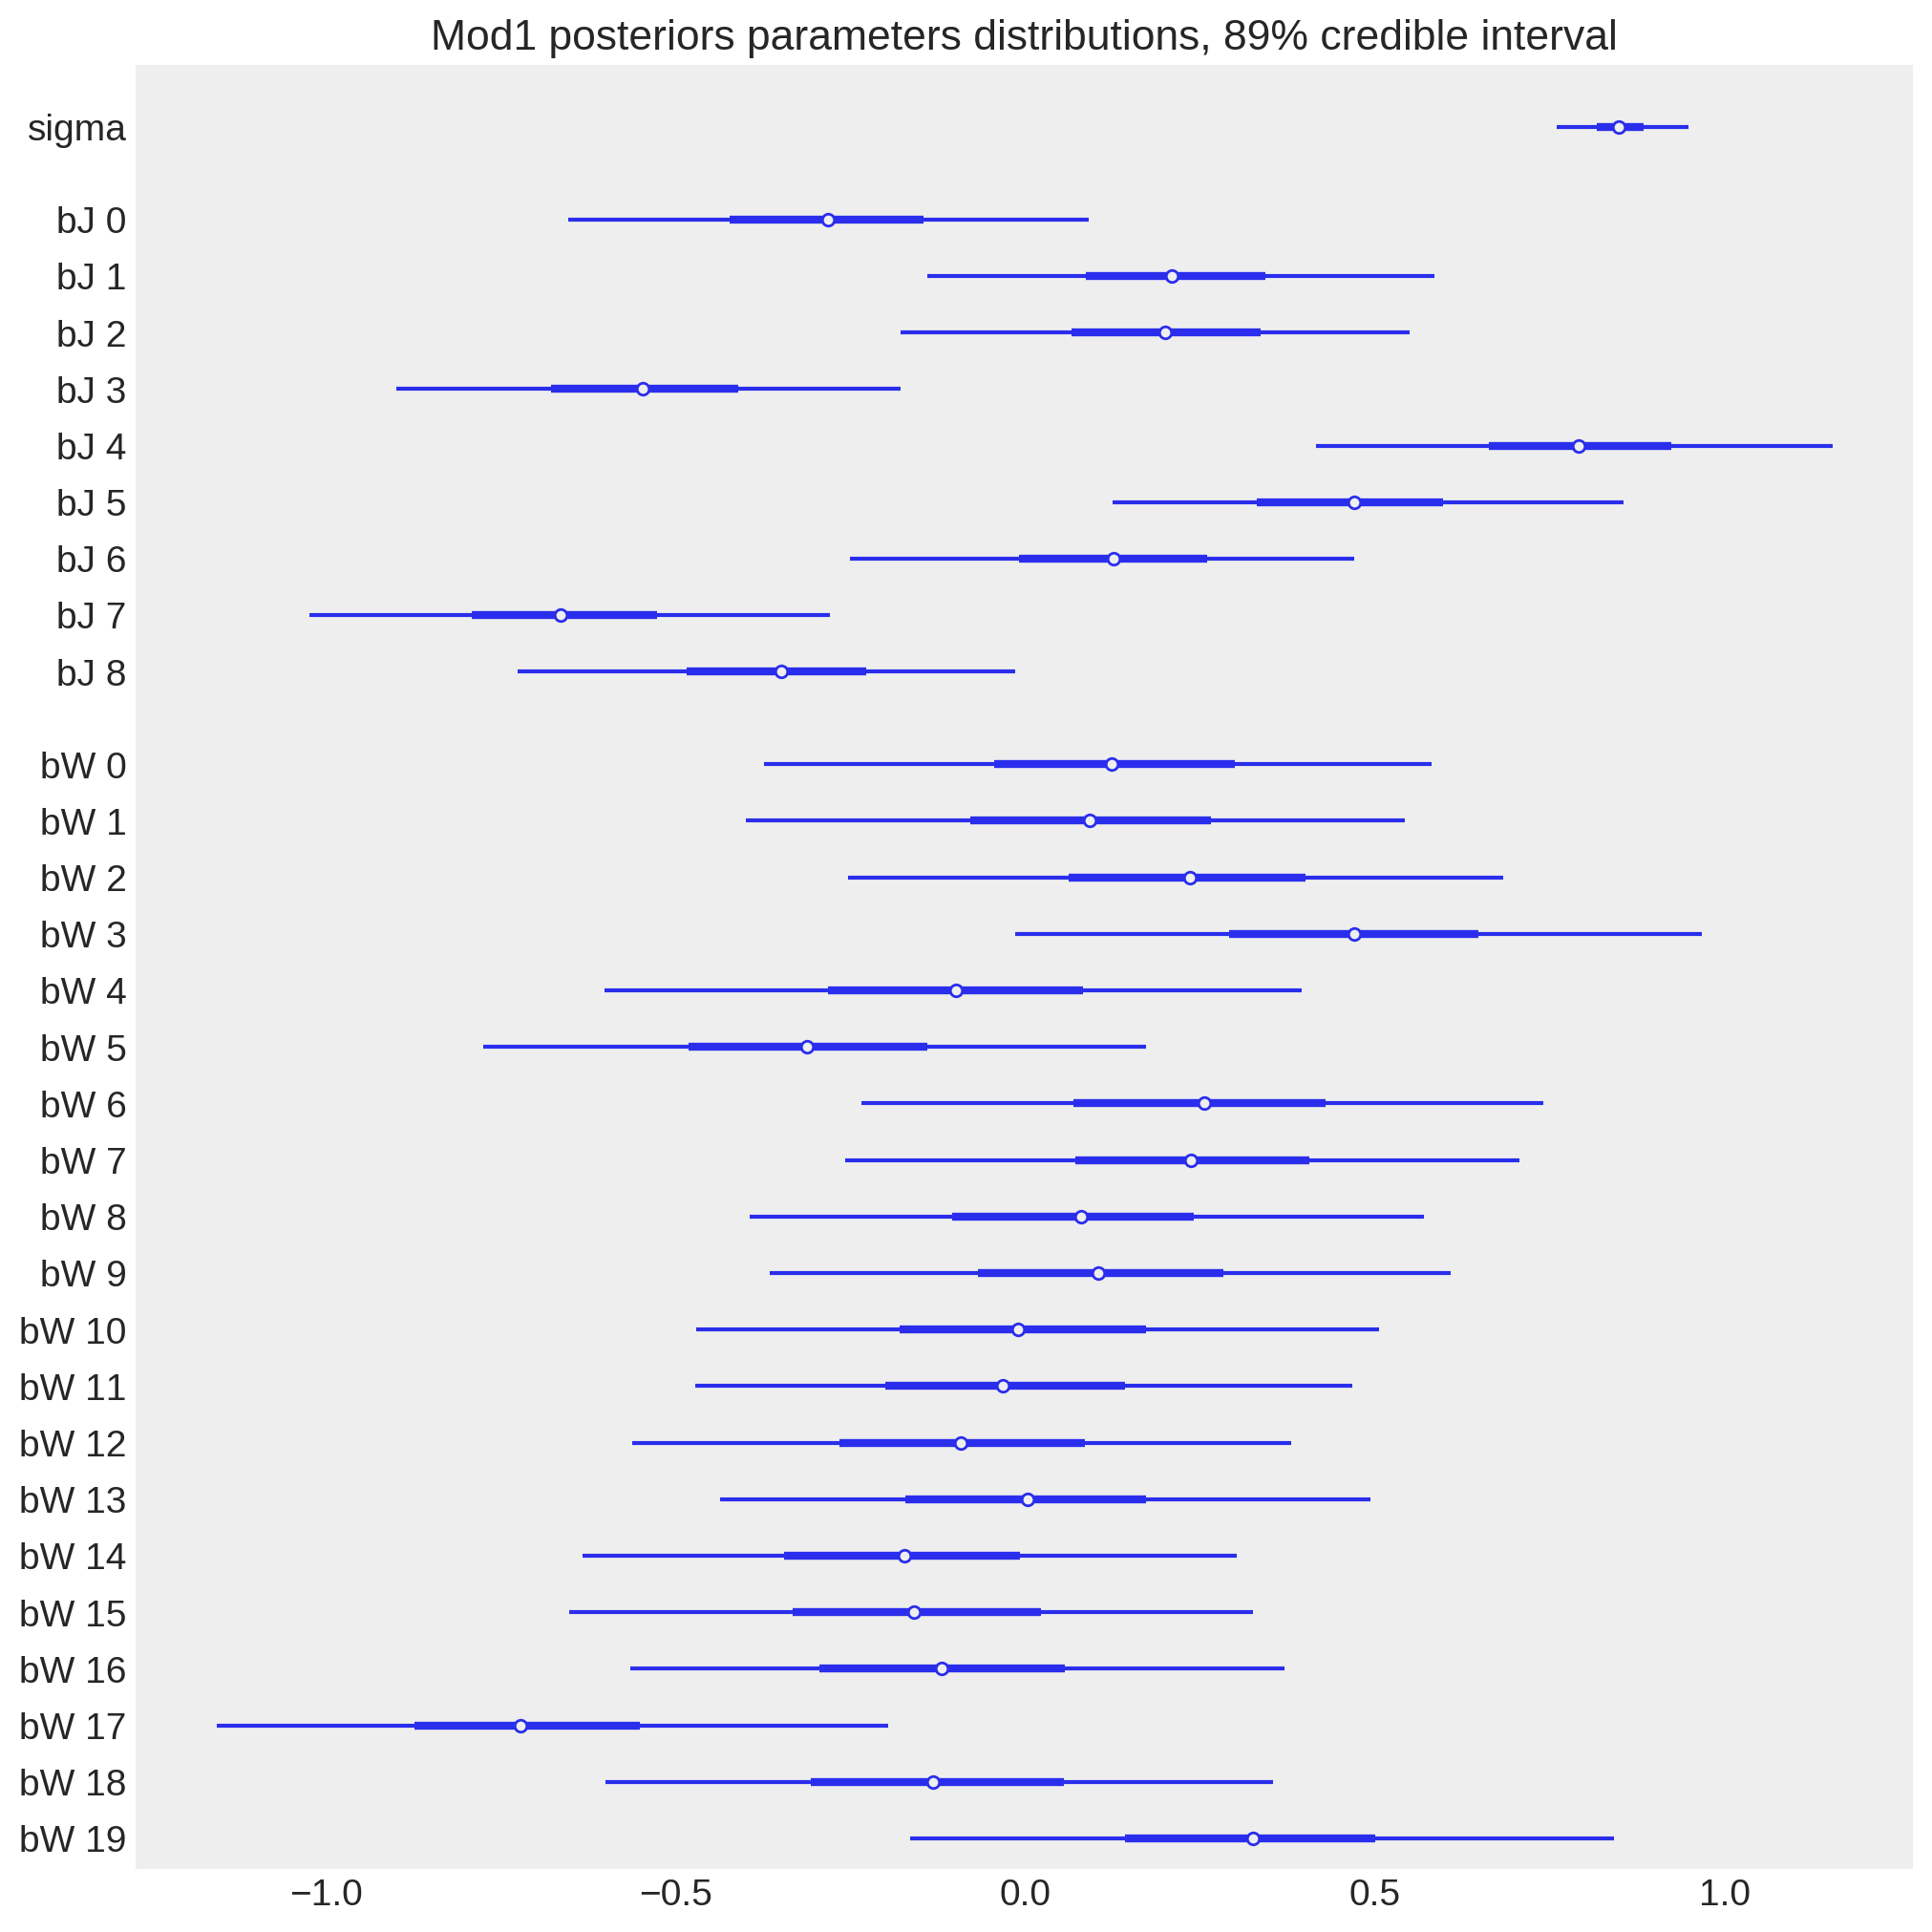

In [11]:
az.style.use('arviz-darkgrid')

fig, axes = az.plot_forest(data,
                           kind='forestplot',
                            combined=True,
#                            ridgeplot_overlap=1,
#                            colors='black',
                           figsize=(10, 10))
axes[0].set_title('Mod1 posteriors parameters distributions, 89% credible interval');

(<Figure size 1000x1000 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9ac077f98>,
       dtype=object))

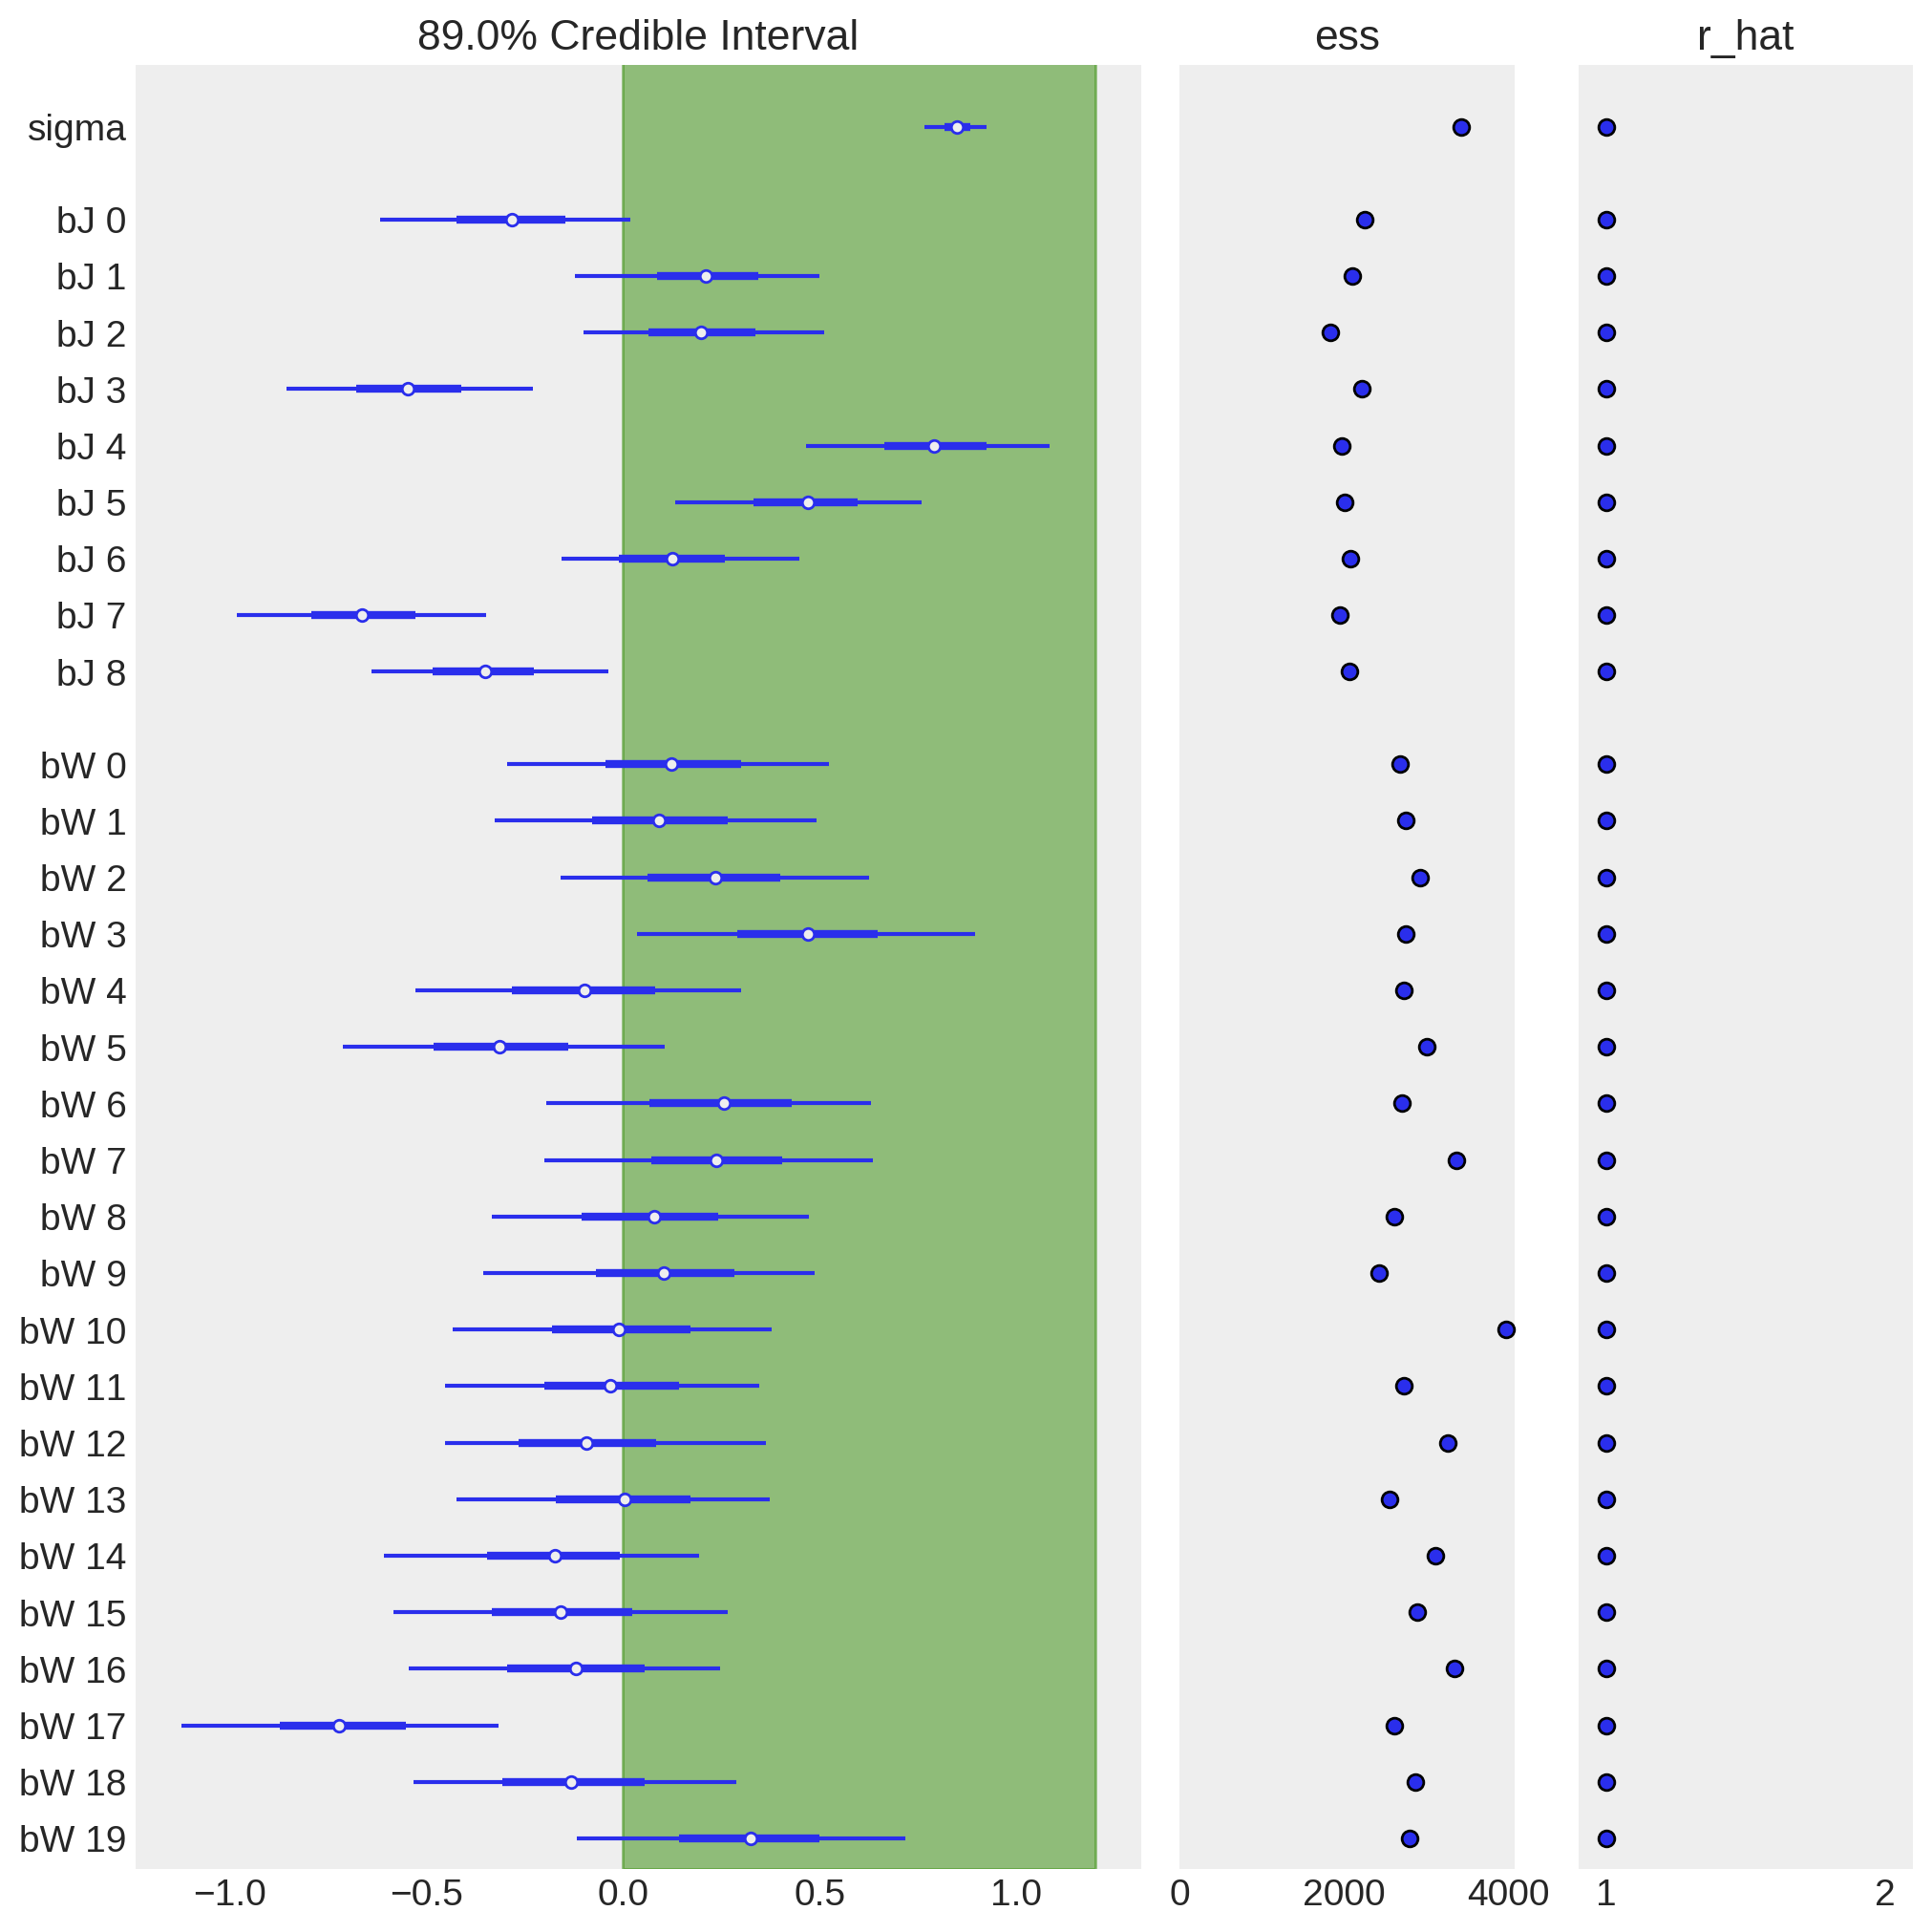

In [12]:
pm.plots.forestplot(data, 
                    kind='forestplot',  
                    combined=True, 
                    credible_interval=0.89, 
                    rope=[0,1.2], 
                    quartiles=True, 
                    ess=True, 
                    r_hat=True,  
                    ridgeplot_overlap=2, 
                    figsize=(10, 10))

The variation in 'biases' of the judges is greater than that of the wines!  Judge 3, 7 and 8 consistently score below average, while judges 4 and 5 score consistently above average.

Wine 3 appears to be the most highly rated wine, with wine 17 the lowest rated wine.

Q2

In [14]:
d.head()

judge flight wine  score  wine.amer  judge.amer
0  Jean-M Cardebat  white   A1   10.0          1           0
1  Jean-M Cardebat  white   B1   13.0          1           0
2  Jean-M Cardebat  white   C1   14.0          0           0
3  Jean-M Cardebat  white   D1   15.0          0           0
4  Jean-M Cardebat  white   E1    8.0          1           0

In [40]:
fid = d['flight'].astype('category').cat.codes
wa = d['wine.amer'].astype('category').cat.codes
ja = d['judge.amer'].astype('category').cat.codes

print(fid.shape, wa.shape, ja.shape, s.shape)

(180,) (180,) (180,) (180,)


The priors can be justified using the same arguments for Question 1, as in the score variable s is standardized, so has range -2 to 2.  Assume the categorical variables in dat2 are 'on average', except for one we are interested in, say wa[1].  It is possible that the presence of american wine (wa=2) could cause the score to move to +2 or -2, but it's unlikely that the judges would on average score in such an extreme way for all american ways (even though blind tasting).  So a standard deviation of 0.5 is justifiable, sd=1 is too much.

In [50]:
with pm.Model() as Mod2:
    #Again, as score is standardized, don't bother with intercept predictor 'a'
    bF = pm.Normal('bF', mu=0, sd=0.5, shape=len(set(fid)))
    bWA = pm.Normal('bWA', mu=0, sd=0.5, shape=len(set(wa)))
    bJA = pm.Normal('bJA', mu=0, sd=0.5, shape=len(set(ja)))
    mu = bF[fid] + bWA[wa] + bJA[ja]
    sigma = pm.Exponential('sigma', lam=1)
    s_hat = pm.Normal('s_hat', mu=mu, sd=sigma, observed=s)
    
    # Prior sampling, trace definition and posterior sampling
    prior_2 = pm.sample_prior_predictive()
    posterior_2 = pm.sample(1000, tune=2500, chains=4, cores=4)
    posterior_pred_2 = pm.sample_posterior_predictive(posterior_2)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bJA, bWA, bF]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:38<00:00, 366.47draws/s]
The acceptance probability does not match the target. It is 0.6660081913539274, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 4000/4000 [00:02<00:00, 1865.05it/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9936117f0>,
      dtype=object)

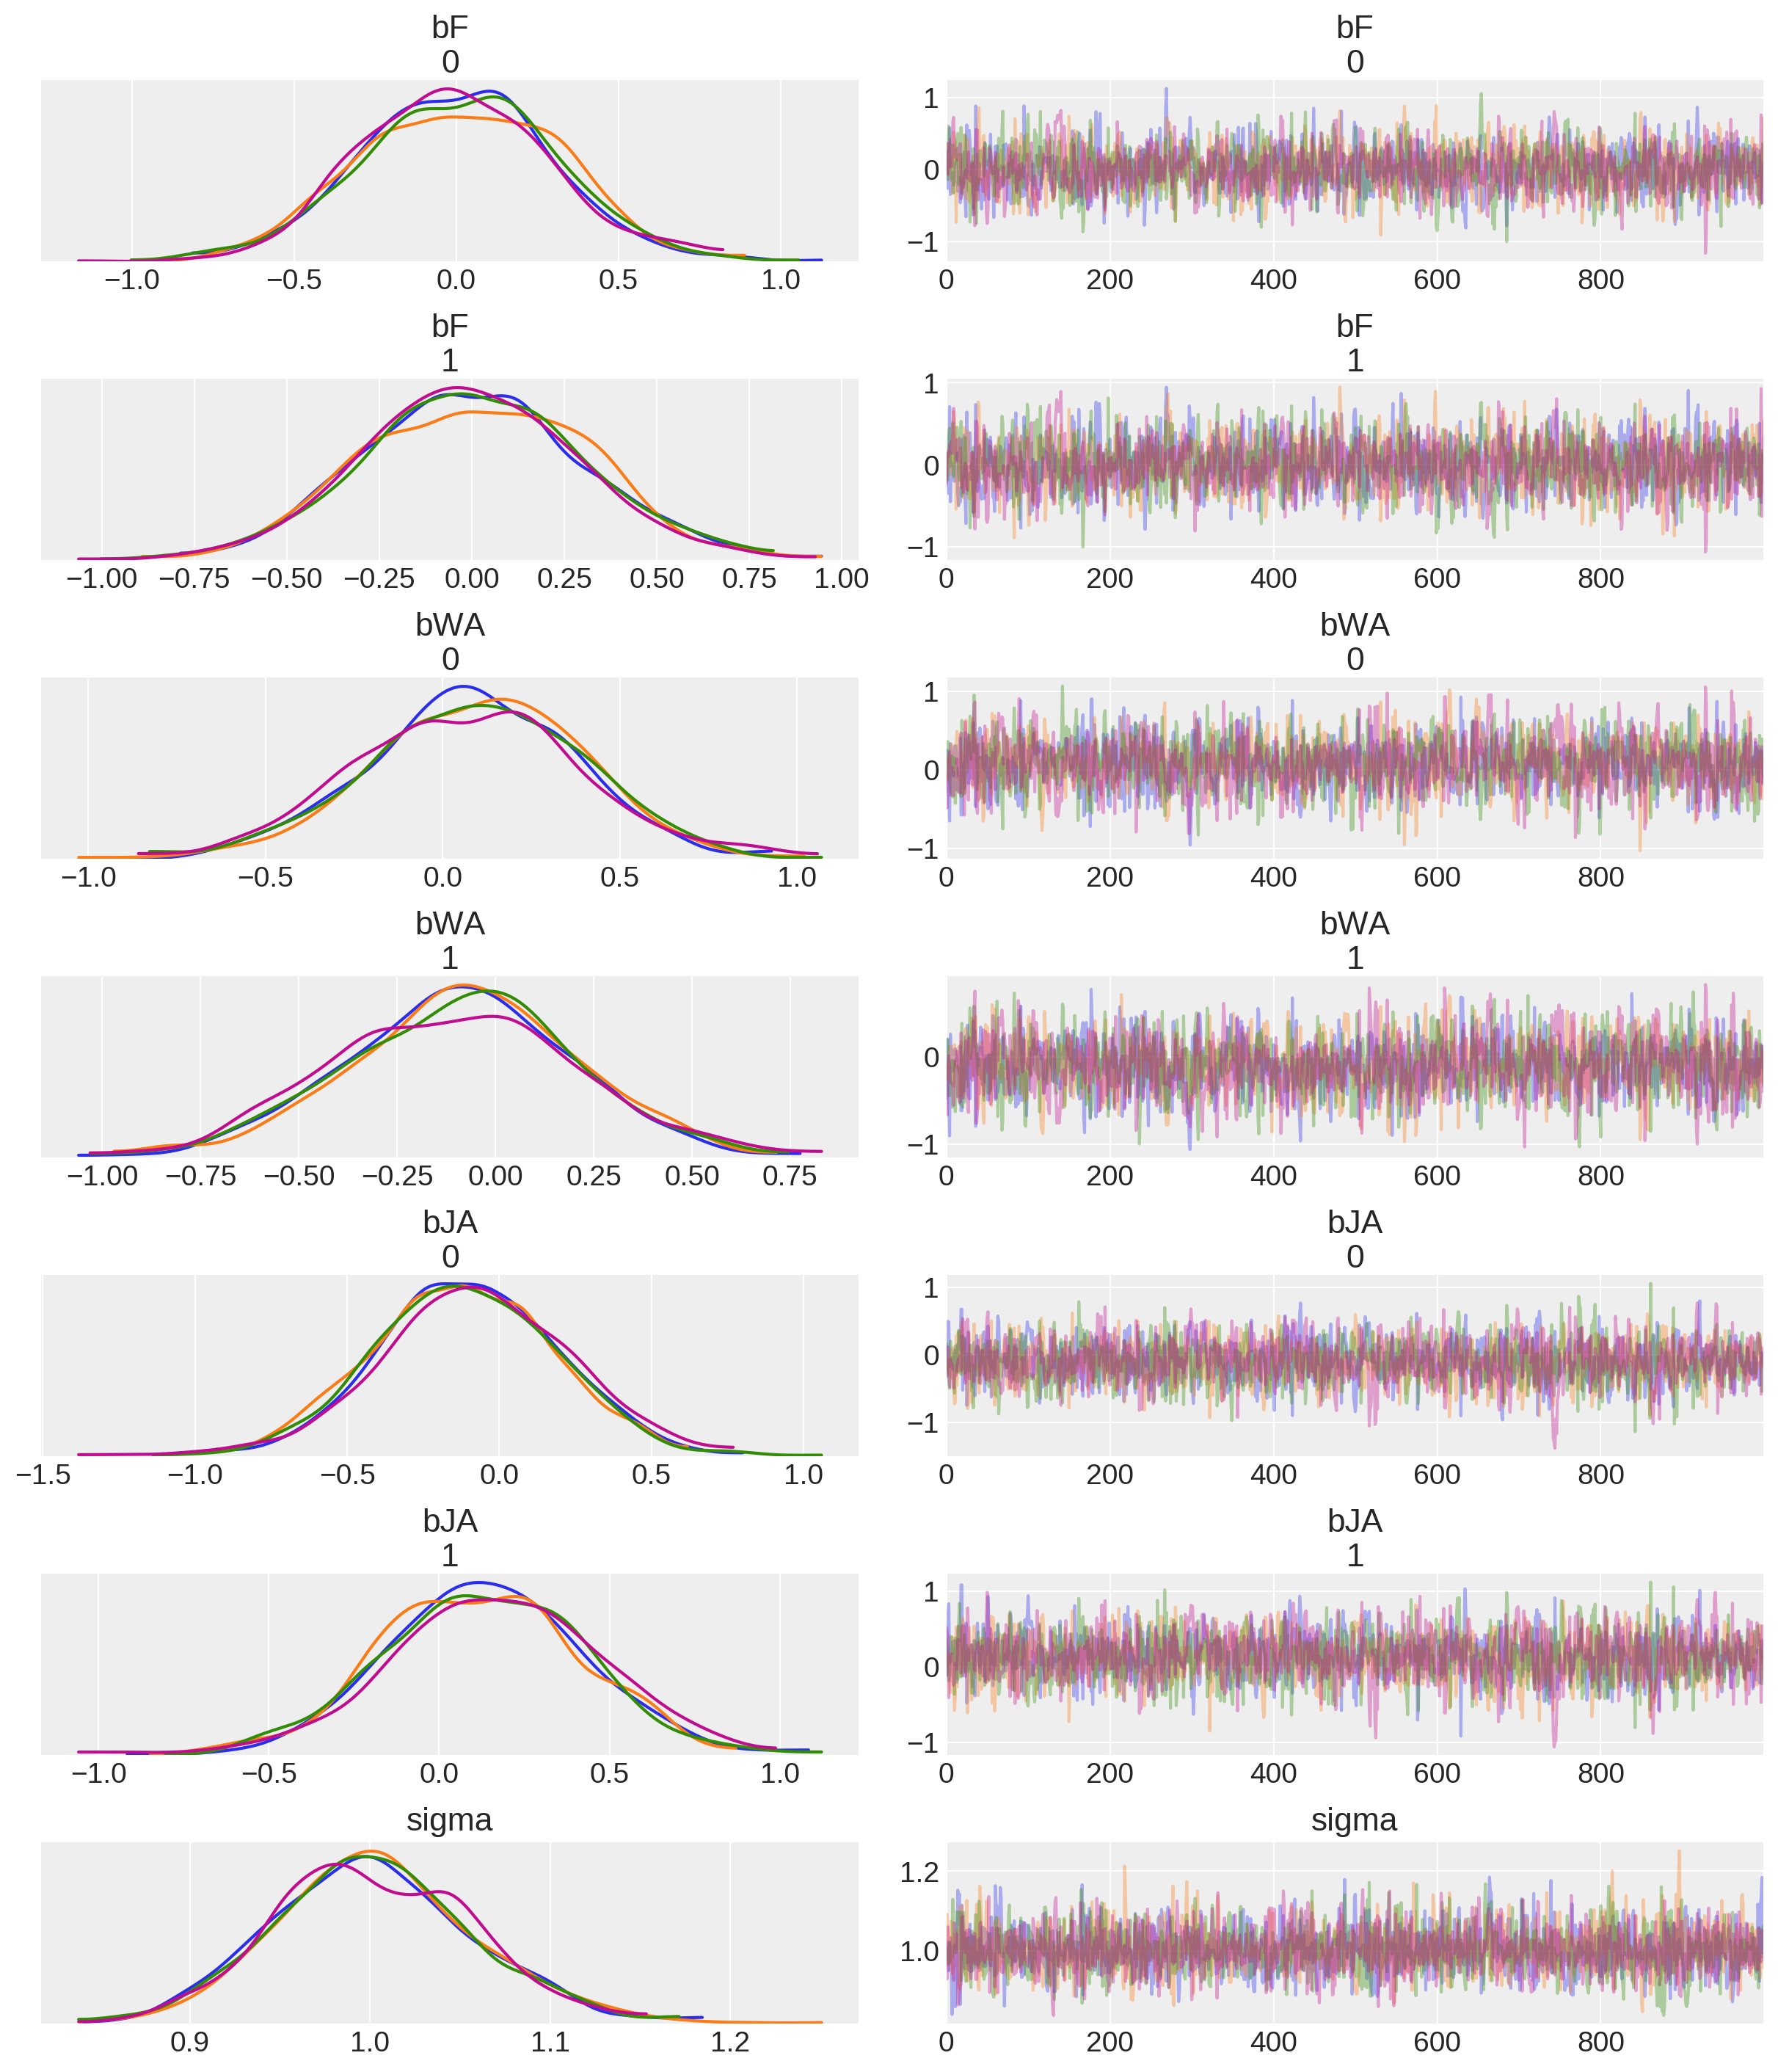

In [51]:
varnames2 = ['bF', 'bWA', 'bJA', 'sigma']
pm.traceplot(posterior_2, varnames2)

In [90]:
az.summary(posterior_2, credible_interval=.89).round(2)

mean    sd  mc error  hpd 5.5%  hpd 94.5%     ess  r_hat
bF[0]  -0.00  0.30      0.01     -0.48       0.45  2186.0    1.0
bF[1]   0.00  0.30      0.01     -0.48       0.46  2241.0    1.0
bWA[0]  0.08  0.30      0.01     -0.42       0.54  2027.0    1.0
bWA[1] -0.10  0.30      0.01     -0.62       0.34  2020.0    1.0
bJA[0] -0.11  0.30      0.01     -0.58       0.37  1957.0    1.0
bJA[1]  0.13  0.30      0.01     -0.32       0.61  1675.0    1.0
sigma   1.00  0.06      0.00      0.91       1.09  2779.0    1.0

In [54]:
data2 = az.from_pymc3(trace=posterior_2,
                     prior=prior2,
                     posterior_predictive=posterior_pred_2)
data2

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

(<Figure size 1000x1000 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff996d65a58>,
       dtype=object))

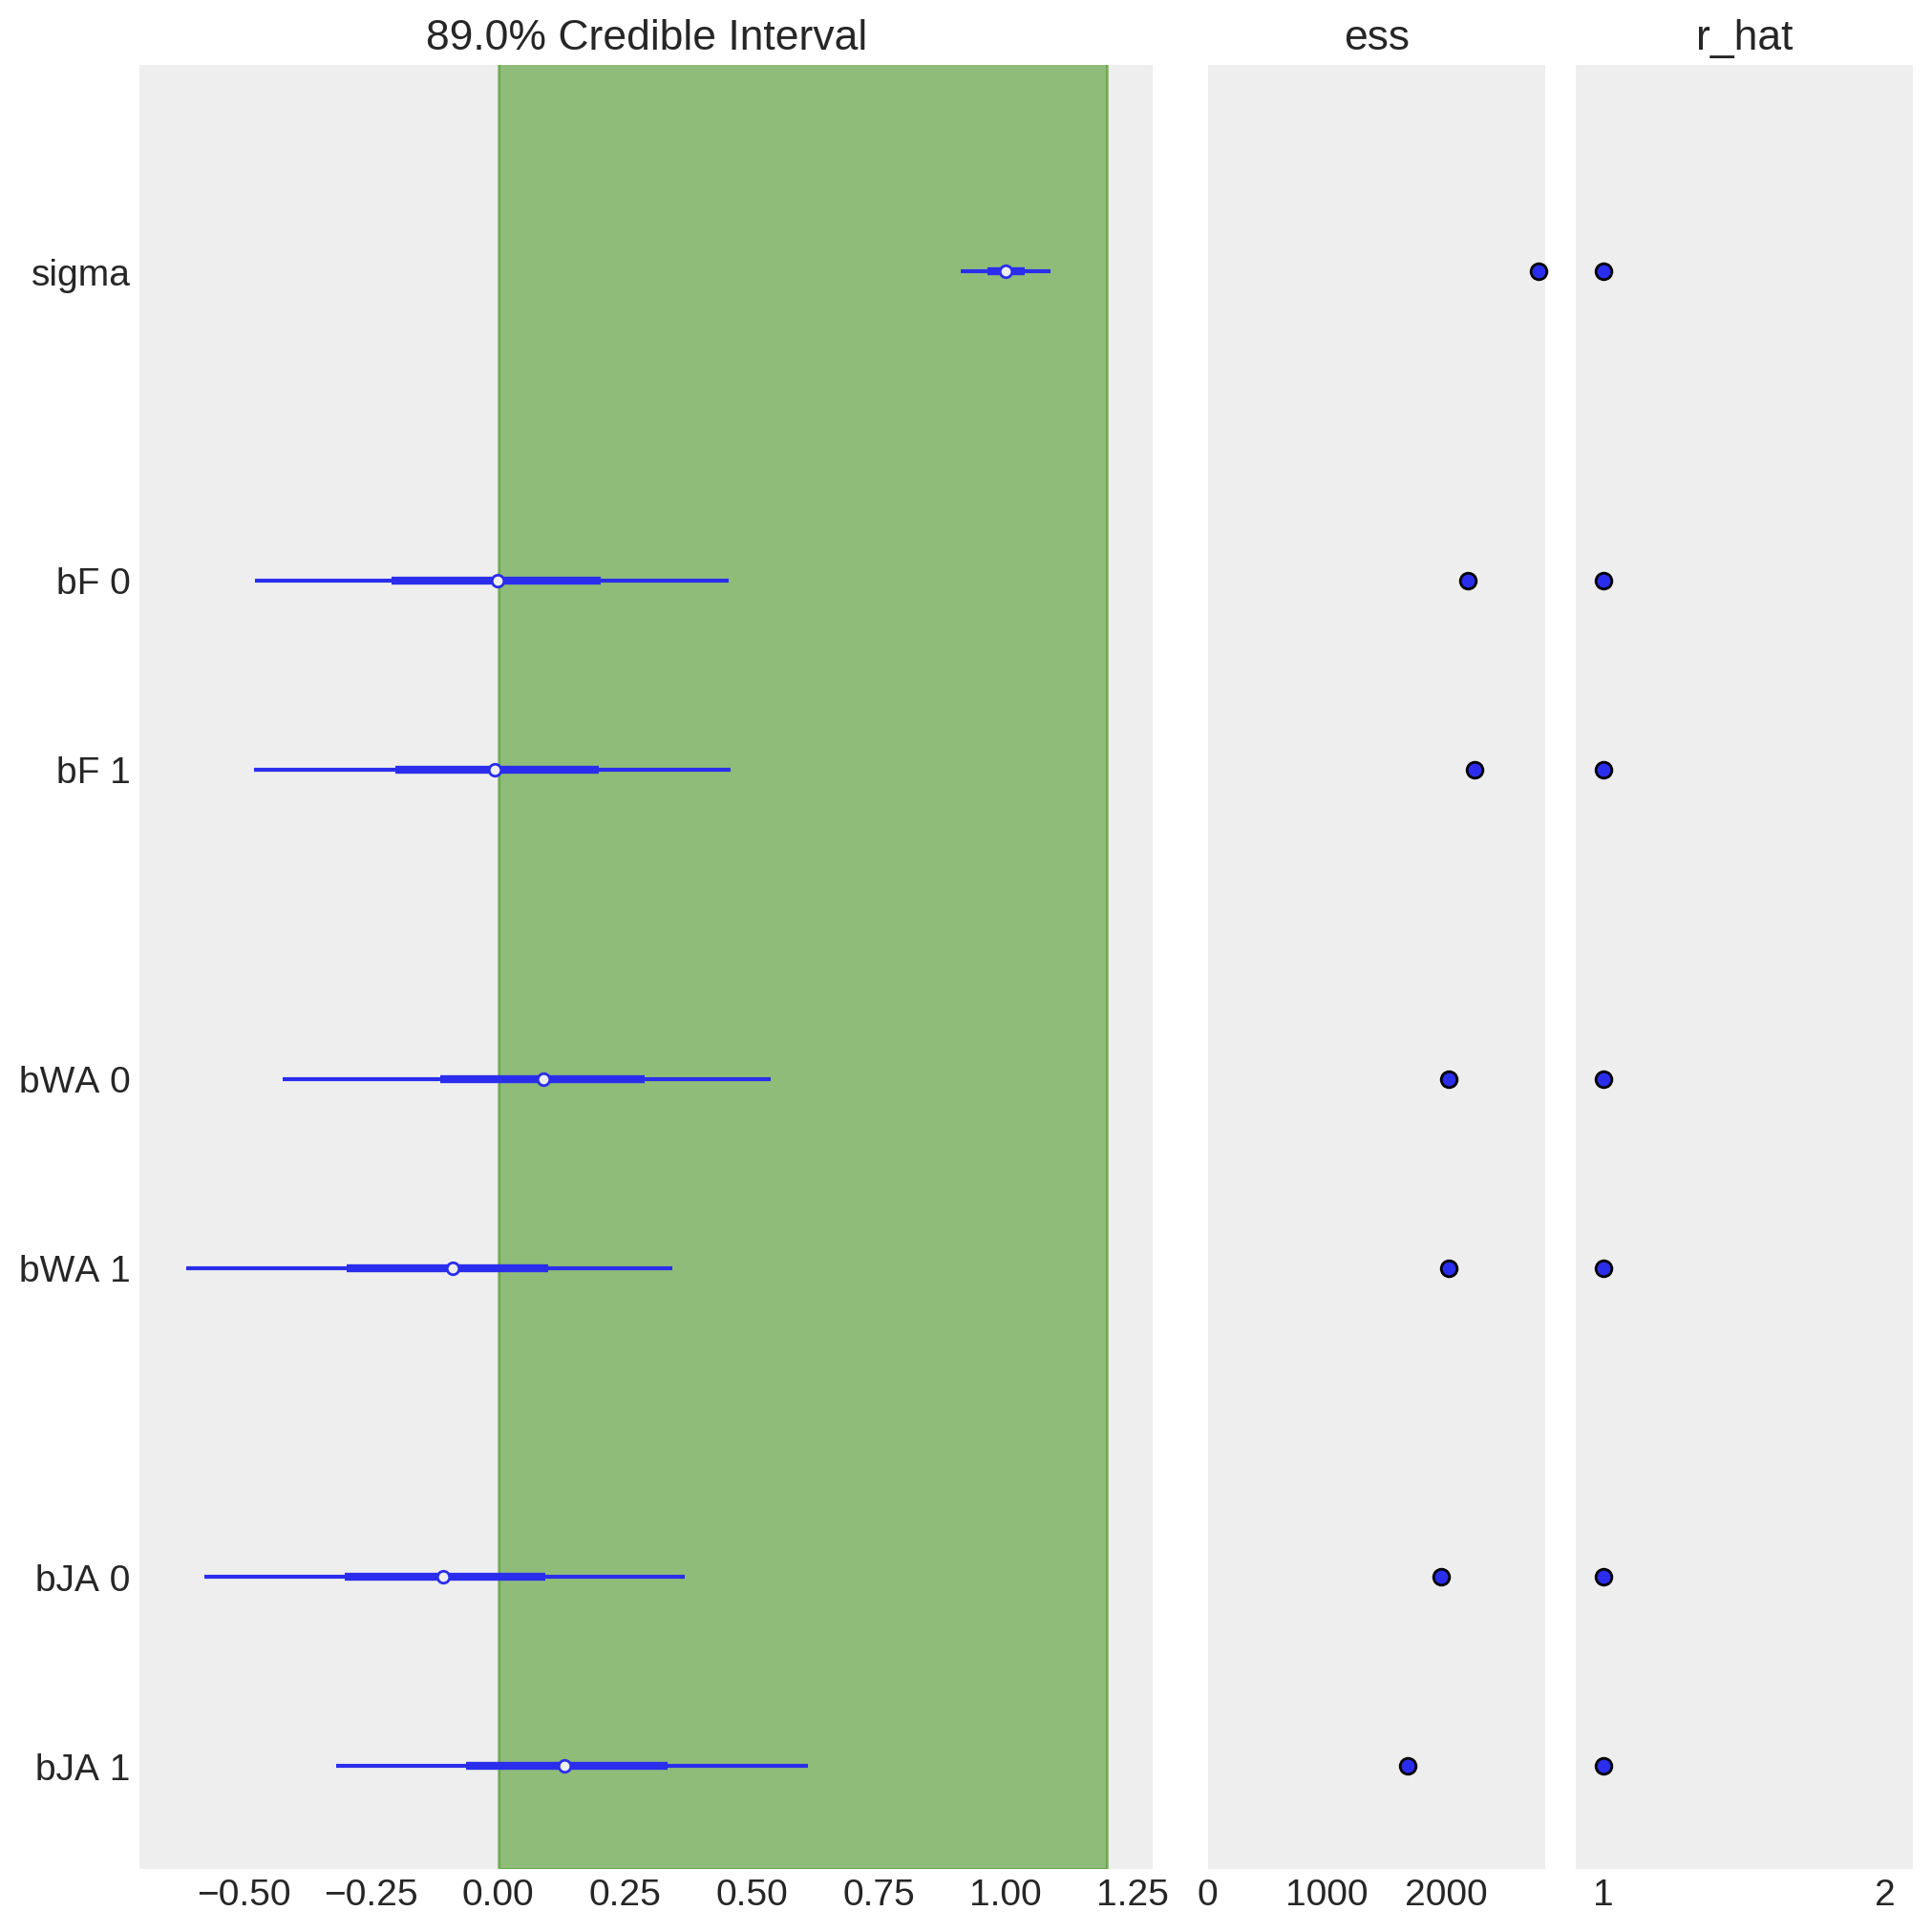

In [55]:
pm.plots.forestplot(data2, 
                    kind='forestplot',  
                    combined=True, 
                    credible_interval=0.89, 
                    rope=[0,1.2], 
                    quartiles=True, 
                    ess=True, 
                    r_hat=True,  
                    ridgeplot_overlap=2, 
                    figsize=(10, 10))

The american judges are slightly more generous in scoring, and french wines do marginally better than the american wines, but there is not much in it.  There's practically no difference between red and white wines (the flight, bF, parameters).  Most of the variation is unexplained - captured in the 'sigma' parameter.

The contrast between American and French wines is:

Mean difference in score (standardized) between American and French wines =  -0.17968873566079338


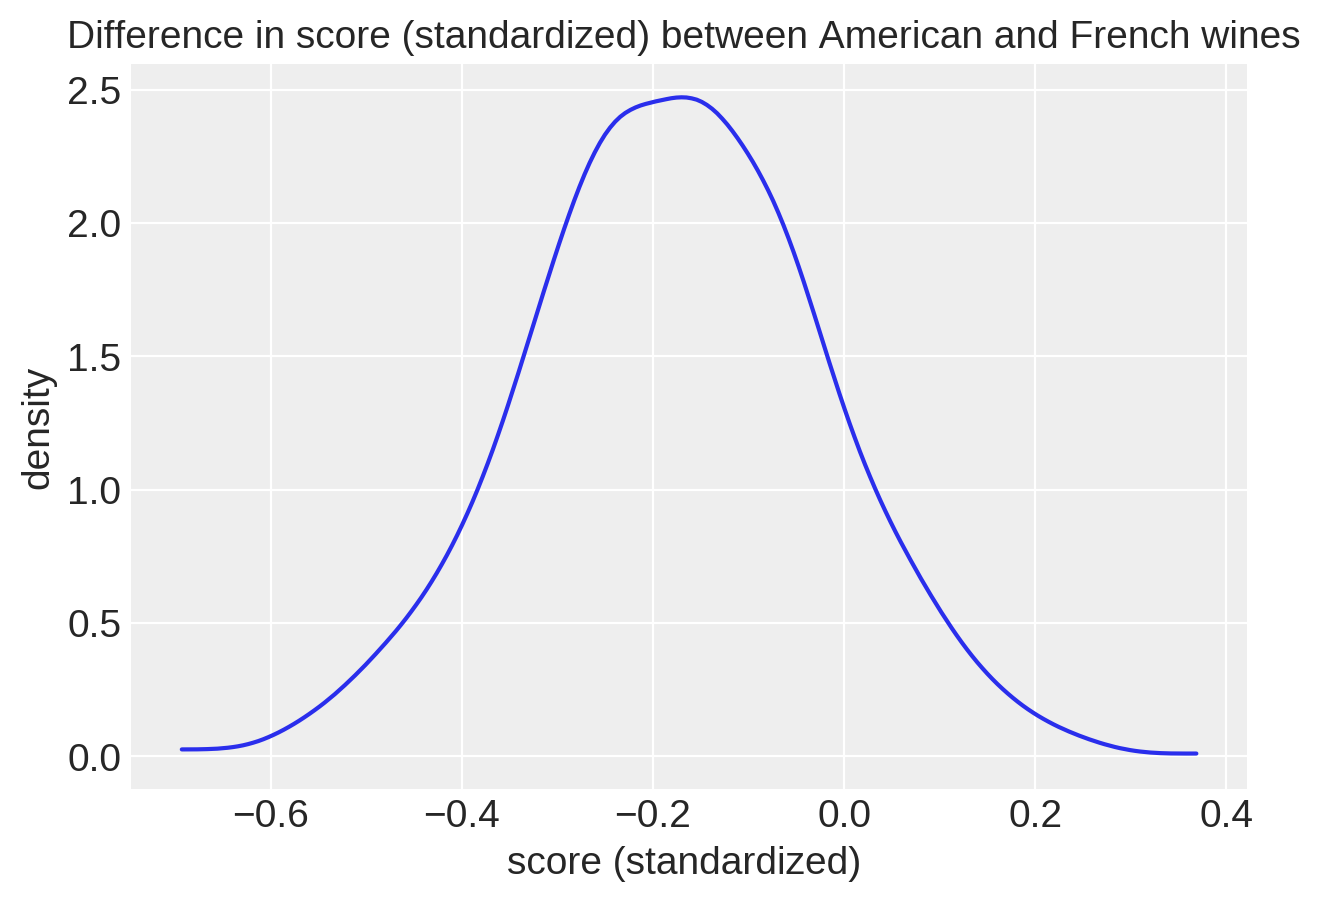

In [79]:
bWAsamples = posterior_2.bWA
diff_wa = bWAsamples[:,1] - posterior_2.bWA[:,0]
diff_wa

print("Mean difference in score (standardized) between American and French wines = ", np.mean(diff_wa))

pm.kdeplot(diff_wa)
plt.xlabel('score (standardized) ', fontsize=14);
plt.ylabel('density', fontsize=14);
plt.title('Difference in score (standardized) between American and French wines ', fontsize=14);

Q3

From McElreath:

Now let’s do an index version. The way to think of this is to make unique parameters for each combination. If we consider all the interactions — including a three-way interaction between nation, judge and flight—there would be 8 combinations and so 8 parameters to estimate. Let’s go ahead and do that, so we can simultaneously consider the 3-way interaction. There are several ways to go about coding this. I’m going to use a trick and make an array of parameters. An array is like a matrix, but can have more than 2 dimensions. If we make a 2-by-2-by-2 array of parameters, then there will be 8 parameters total and we can access each by just using these index variables:

The interaction term meanings for the indicator version of the model:

w[1,0,1] (would be bFWA) - the expected change in the (sensititivity (i.e. change) of the standardized score to wine flight) due to the origin of the wine.... or the expected change in the (sensititivity (i.e. change) of the standardized score to wine origin) due to the flight of the wine (i.e. when the wine is red or white).

w[0,1,1] (would be bFJA) - the expected change in the (sensititivity (i.e. change) of the standardized score to wine flight) due to the nationality of the judge.... or the expected change in the (sensititivity (i.e. change) of the standardized score to judge nationality) due to the flight of the wine (i.e. when the wine is red or white).

w[1,1,0] (would be bWAJA) - the expected change in the (sensititivity (i.e. change) of the standardized score to wine origin) due to nationality of the judge.... or the expected change in the (sensititivity (i.e. change) of the standardized score to judge nationality) due to the origin of the wine.

From McElreath: "I used the same priors as before for the main effects. I used tighter priors for the interactions (in the indicator version, not index version of model). Why? Because interactions represent sub-categories of data, and if we keep slicing up the sample, differences can’t keep getting bigger. Again, the most important thing is not to use flat priors like Normal(0,10) that produce impossible outcomes."

For the index version of the model, the coefficients below represent the bias / average deviation from a standardized score of 0 due to the particular case of origin of wine, nationality of judge and flight of the wine.

w[wa, ja, fid]. Index is thus a tuple (wa, ja, fid). Given the definitions in the data (1 = french, 2 = american for both wine (wa) and judges (ja), and flight id is 1 = red, 2 = white). Thus:

w[g1, 1, 1] == coefficient for french wine, french judge and red wine.

w[1, 1, 2] == coefficient for french wine, french judge and white wine.

w[1, 2, 1] == coefficient for french wine, american judge, red wine.

w[1, 2, 2] == coefficient for french wine, american judge, white wine.

w[2, 1, 1] == coefficient for american wine, french judge, red wine.

w[2, 1, 2] == coefficient for american wine, french judge, white wine.

w[2, 2, 1] == coefficient for american wine, american judge and red wine.

w[2, 2, 1] == coefficient for american wine, american judge and white wine.


In [85]:
with pm.Model() as Mod3:
    #Again, as score is standardized, don't bother with intercept predictor 'a'
#     w = pm.Normal('w', mu=0, sd=0.5, shape=(len(set(wa)), len(set(ja)), len(set(fid))))
#     mu = w[wa][ja][fid]
  
    # Priors
    w = pm.Normal('w', mu=0, sd=0.5, shape=len(d['wine.amer'].unique()))
    j = pm.Normal('j', mu=0, sd=0.5, shape=len(d['judge.amer'].unique()))
    f = pm.Normal('f', mu=0, sd=0.5, shape=len(d['flight'].unique()))
    wj = pm.Normal('wj', mu=0, sd=0.25, shape=len(d['wine.amer'].unique())*len(d['judge.amer'].unique()))
    wf = pm.Normal('wf', mu=0, sd=0.25, shape=len(d['wine.amer'].unique())*len(d['flight'].unique()))
    jf = pm.Normal('jf', mu=0, sd=0.25, shape=len(d['judge.amer'].unique())*len(d['flight'].unique()))
    wjf = pm.Normal('wjf', mu=0, sd=0.1, shape=len(d['wine.amer'].unique())*len(d['judge.amer'].unique())*len(d['flight'].unique()))
    sigma = pm.Exponential('sigma', lam=1)
    
    # Regression
    mu = w[wa] + j[ja] + f[fid] + wj[wa*ja] + wf[wa*fid] + jf[ja*fid] + wjf[wa*ja*fid]
    s_hat = pm.Normal('s_hat', mu=mu, sd=sigma, observed=s)
    
    # Prior sampling, trace definition and posterior sampling
    prior_3 = pm.sample_prior_predictive()
    posterior_3 = pm.sample(1000, tune=2500, chains=4, cores=4)
    posterior_pred_3 = pm.sample_posterior_predictive(posterior_3)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, wjf, jf, wf, wj, f, j, w]
100%|██

In [89]:
az.summary(posterior_3, credible_interval=.89).round(2)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


mean    sd  mc error  hpd 5.5%  hpd 94.5%     ess  r_hat
w[0]    0.16  0.33      0.01     -0.36       0.69  2118.0    1.0
w[1]   -0.14  0.32      0.01     -0.64       0.38  2103.0    1.0
j[0]   -0.13  0.34      0.00     -0.67       0.42  1815.0    1.0
j[1]    0.16  0.32      0.01     -0.35       0.67  1741.0    1.0
f[0]    0.08  0.32      0.01     -0.43       0.59  2211.0    1.0
f[1]   -0.08  0.32      0.01     -0.59       0.42  2064.0    1.0
wj[0]   0.04  0.20      0.00     -0.28       0.37  3741.0    1.0
wj[1]  -0.02  0.20      0.00     -0.33       0.32  3800.0    1.0
wj[2]   0.00  0.25      0.00     -0.38       0.40  5012.0    1.0
wj[3]   0.00  0.24      0.00     -0.37       0.40  4922.0    1.0
wf[0]  -0.14  0.20      0.00     -0.47       0.18  3412.0    1.0
wf[1]   0.17  0.20      0.00     -0.15       0.50  3259.0    1.0
wf[2]  -0.01  0.25      0.00     -0.39       0.42  4567.0    1.0
wf[3]   0.01  0.26      0.00     -0.43       0.38  5334.0    1.0
jf[0]   0.01  0.20      0.00     -0.31       0.32  3365.0    1.0
jf[1]  -0.00  0.21      0.00     -0.36       0.31  3348.0    1.0
jf[2]   0.00  0.26      0.00     -0.40       0.42  3849.0    1.0
jf[3]  -0.00  0.24      0.00     -0.39       0.38  4229.0    1.0
wjf[0]  0.01  0.10      0.00     -0.14       0.17  3898.0    1.0
wjf[1] -0.01  0.10      0.00     -0.16       0.14  4808.0    1.0
wjf[2]  0.00  0.10      0.00     -0.14       0.17  4149.0    1.0
wjf[3] -0.00  0.10      0.00     -0.17       0.16  4904.0    1.0
wjf[4] -0.00  0.10      0.00     -0.16       0.15  4774.0    1.0
wjf[5]  0.00  0.10      0.00     -0.16       0.15  4993.0    1.0
wjf[6]  0.00  0.10      0.00     -0.16       0.16  5030.0    1.0
wjf[7]  0.00  0.10      0.00     -0.17       0.15  5012.0    1.0
sigma   1.00  0.05      0.00      0.92       1.09  4477.0    1.0

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff98b26ae80>,
      dtype=object)

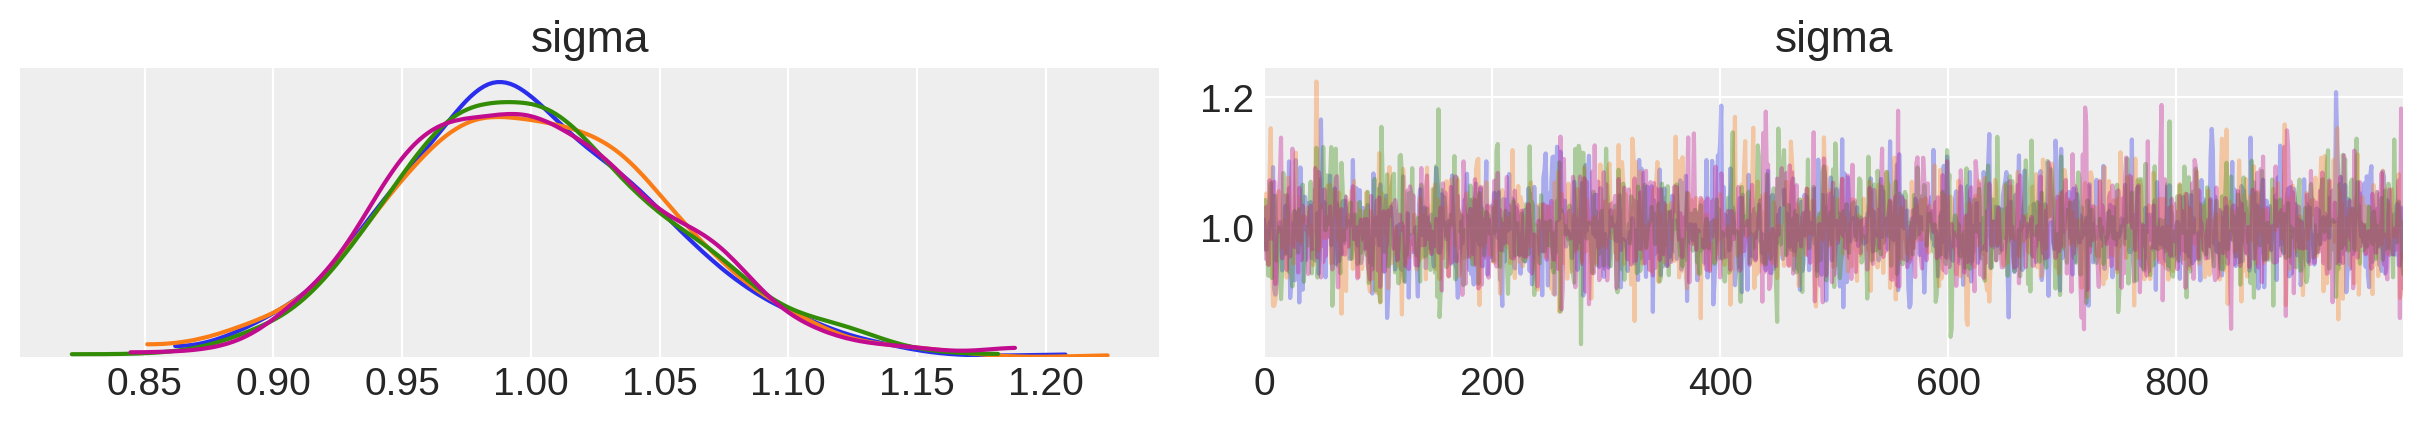

In [92]:
varnames3 = ['bF', 'bWA', 'bJA', 'sigma']
pm.traceplot(posterior_3, varnames3)

In [104]:
d = d.assign(s_hat_3=np.mean(posterior_pred_3['s_hat'],axis=0),
             s_hat_2=np.mean(posterior_pred_2['s_hat'],axis=0))
aux = d.groupby(['wine.amer', 'judge.amer','flight'])['score','s_hat_2','s_hat_3'].mean().reset_index()
combinations = ['FFR', 'FFW', 'FAR', 'FAW', 'AFR', 'AFW', 'AAR', 'AAW'] # wine, judge, flight order
aux['combination'] = combinations

In [105]:
aux

wine.amer  judge.amer flight      score   s_hat_2   s_hat_3 combination
0          0           0    red  14.875000 -0.019930  0.039239         FFR
1          0           0  white  13.187500 -0.023282 -0.136548         FFW
2          0           1    red  15.050000  0.215182  0.318903         FAR
3          0           1  white  14.725000  0.217408  0.140265         FAW
4          1           0    red  13.083333 -0.206454 -0.266301         AFR
5          1           0  white  14.312500 -0.202123 -0.119829         AFW
6          1           1    red  14.150000  0.033867 -0.039438         AAR
7          1           1  white  14.316667  0.037497  0.070528         AAW

In [119]:
aux_plot = aux.melt(id_vars=['combination'],
                    value_vars=['score','s_hat_2', 's_hat_3'],
                    var_name='score_origin',
                    value_name='scores')

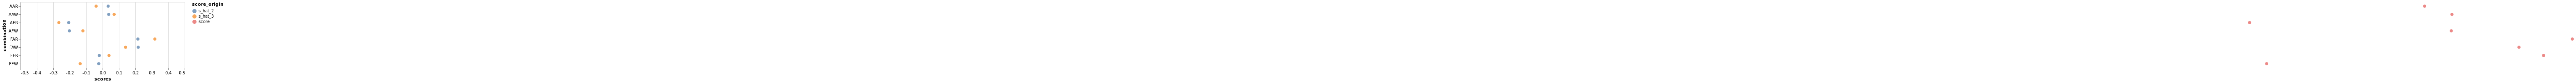

In [116]:
plot = alt.Chart(aux_plot)\
   .mark_circle(size = 60)\
   .encode(
        x=alt.X('scores', title='scores',scale=alt.Scale(domain=(-0.5, 0.5))),
        y=alt.Y('combination', title='combination'),
        color='score_origin'
          )

plot